# Unified CEBRA Encoders for Integrating Neural Recordings via Behavioral Alignment

This is a demo notebook to run our proposed unified CEBRA encoder on the rat hippocampus navigation dataset presented in the manuscript ([Grosmark & Buzáki, Science, 2016](https://www.science.org/doi/full/10.1126/science.aad1935)).

**ABSTRACT:** Analyzing neural activity across diverse recording sessions with varying neuron counts remains a challenge for neuroscientists. To address this, we propose a novel unified encoder model using supervised contrastive learning built on CEBRA. Our approach, using a novel sampling scheme, aligns neural data from different sessions by matching shared labels at specific time points. This can be more strongly supervised with a behaviorally-based hypothesis, or weakly supervised with a general label, such as trial timing or other fiduciary label. A single encoder is then trained to learn a common latent space where similar labels correspond to similar neural representations, regardless of which neurons were recorded. This method effectively handles datasets with limited neuron counts and leverages pooled data to produce high-performance unified encoders that can be used to study neural representations or in downstream tasks, such as decoding. We demonstrate improved behavioral decoding on various tasks compared to existing methods. Crucially, our solution is computationally efficient and fast to train, requiring significantly fewer resources than large-scale alternatives, providing a practical tool for analyzing population-level neural computations across diverse experiments. We demonstrate its utility in motor control in monkeys and mice, navigation in rats, and in vision.

In [ ]:
!pip install --pre 'cebra[datasets,demos]'

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import numpy as np

import cebra
from cebra.integrations.plotly import plot_embedding_interactive
from plotly.subplots import make_subplots

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Load the datasets
hippocampus_a = cebra.datasets.init('rat-hippocampus-single-achilles')
hippocampus_b = cebra.datasets.init('rat-hippocampus-single-buddy')
hippocampus_c = cebra.datasets.init('rat-hippocampus-single-cicero')
hippocampus_g = cebra.datasets.init('rat-hippocampus-single-gatsby')

datasets = [hippocampus_a, hippocampus_b, hippocampus_c, hippocampus_g]

In [3]:
# Split data and labels (labels we use later!)
from sklearn.model_selection import train_test_split

train_data, valid_data = [], []
train_continuous_label, valid_continuous_label = [], []
for i, dataset in enumerate(datasets):
    split_idx = int(0.8 * len(dataset.neural)) #suggest: 5%-20% depending on your dataset size

    train_data.append(dataset.neural[:split_idx])
    valid_data.append(dataset.neural[split_idx:])

    train_continuous_label.append(dataset.continuous_index.numpy()[:split_idx])
    valid_continuous_label.append(dataset.continuous_index.numpy()[split_idx:])
    
train_datasets = [
    cebra.data.TensorDataset(
        neural=train_data[i], continuous=train_continuous_label[i], device=device
    )
    for i in range(len(train_data))
]

valid_datasets = [
    cebra.data.TensorDataset(valid_data[i], continuous=valid_continuous_label[i], device=device)
    for i in range(len(valid_data))
]

In [4]:
# Hyper parameters from the CEBRA paper.
config = {"model_architecture": "offset10-model",
    "batch_size": 512, 
    "output_dimension": 3,
    "time_offsets": 10,
    "learning_rate": 0.003,
    "num_hidden_units": 32,
    "temperature": 1,
    "max_iterations": 5000,
    "conditional": "time_delta",
    "verbose": True,
}

### Train model using the torch API

In [5]:
# Number of neurons = sum of neurons in all datasets
num_neurons = 0
for dataset in train_datasets:
    num_neurons += dataset.neural.shape[1]

# Define the dataset
dataset = cebra.data.UnifiedDataset(dataset for dataset in train_datasets)
dataset.to(device)

# Define the dataset loader
loader = cebra.data.UnifiedLoader(
    dataset,
    conditional=config["conditional"],
    num_steps=config["max_iterations"],
    batch_size=config["batch_size"],
    time_offset=config["time_offsets"],
)

dataset.to(device)

# Define the model
model = cebra.models.init(
    config["model_architecture"],
    num_neurons=num_neurons,
    num_units=config["num_hidden_units"],
    num_output=config["output_dimension"],
)
model.to(device)
dataset.configure_for(model)

criterion = cebra.models.FixedCosineInfoNCE(temperature=config["temperature"])
criterion.to(device)
optimizer = torch.optim.Adam(list(model.parameters()), lr=config["learning_rate"])

# Define the solver
solver = cebra.solver.UnifiedSolver(
    model=model, criterion=criterion, optimizer=optimizer, tqdm_on=config["verbose"]
)

In [6]:
# Train solver 
solver.fit(loader)

pos: -0.9776 neg:  6.4070 total:  5.4293 temperature:  1.0000: 100%|██████████| 5000/5000 [10:50:34<00:00,  7.81s/it]      


In [7]:
solver.save("cebra_model")

### Visualize the InfoNCE loss & goodness of fit.

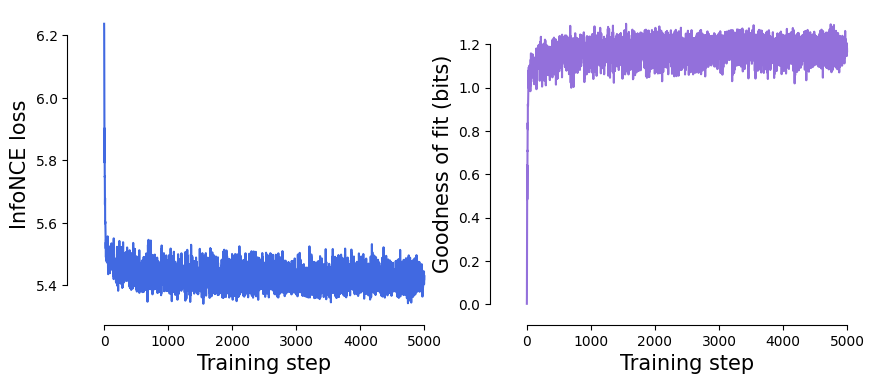

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(solver.history, c="royalblue")
axes[0].set_xlabel("Training step", fontsize=15)
axes[0].set_ylabel("InfoNCE loss", fontsize=15)

axes[1].plot(cebra.sklearn.metrics.infonce_to_goodness_of_fit(infonce=solver.history, 
                                                              batch_size=config["batch_size"],
                                                              num_sessions=1), 
                                                              c="mediumpurple")
axes[1].set_xlabel("Training step", fontsize=15)
axes[1].set_ylabel("Goodness of fit (bits)", fontsize=15)

sns.despine(
        left=False,
        right=True,
        bottom=False,
        top=True,
        trim=True,
        offset={"bottom": 5, "left": 15},
)

### Get the embeddings for each session.

In [9]:
# This is similar to the multisession CEBRA-Behaviour API, but you add the labels at inference

embeddings = {}
for i in range(len(train_datasets)):
    embeddings[i] = solver.transform([train_datasets[j].neural for j in range(len(train_datasets))],
                                     labels=[train_datasets[j].continuous for j in range(len(train_datasets))], #NOTE: labels at inference
                                     session_id = i,
                                     batch_size=300).cpu().numpy()

In [10]:
alpha = 0.5

cols = len(embeddings)
fig = make_subplots(
    rows=1,
    cols=cols,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}]],
    subplot_titles=tuple(
        np.array(
            [f"Rat {str(i+1)}" for i in range(len(embeddings))]
        )
    ),
    vertical_spacing=0,
    horizontal_spacing=0.0,
)

for i in range(len(embeddings)):
    label = train_datasets[i].continuous.cpu().numpy()
    
    r_ind = label[:, 1] == 1
    l_ind = label[:, 2] == 1
    r_map = "cool"
    l_map = "magma"
    r_c = label[r_ind, 0]
    l_c = label[l_ind, 0]

    fig = plot_embedding_interactive(
        embeddings[i][r_ind],
        r_c,
        cmap=r_map,
        axis=fig,
        row=1,
        col=i+1,
        opacity=alpha,
        title="",
    )
    
    fig = plot_embedding_interactive(
        embeddings[i][l_ind],
        l_c,
        cmap=l_map,
        axis=fig,
        row=1,
        col=i+1,
        opacity=alpha,
        title="",
    )
    
dict_layout = dict(
        xaxis = dict(
            backgroundcolor="rgba(0, 0, 0, 0)",
            gridcolor="rgba(0, 0, 0, 0)",
            showbackground=True,
            zerolinecolor="white",
        ),
        yaxis = dict(
            backgroundcolor="rgba(0, 0, 0, 0)",
            gridcolor="rgba(0, 0, 0, 0)",
            showbackground=True,
            zerolinecolor="white",
        ),
        zaxis = dict(
            backgroundcolor="rgba(0, 0, 0, 0)",
            gridcolor="rgba(0, 0, 0, 0)",
            showbackground=True,
            zerolinecolor="white",
        ))
            
fig.update_layout(
    scene = dict_layout,
    scene2= dict_layout,
    scene3= dict_layout,
    scene4= dict_layout,
    width=800,
    height=400,
)
    
fig.show()

# Uncomplete range of behaviors

Now, let's imagine that the full range of behavior is not available in some sessions. What will their embeddings look like? 

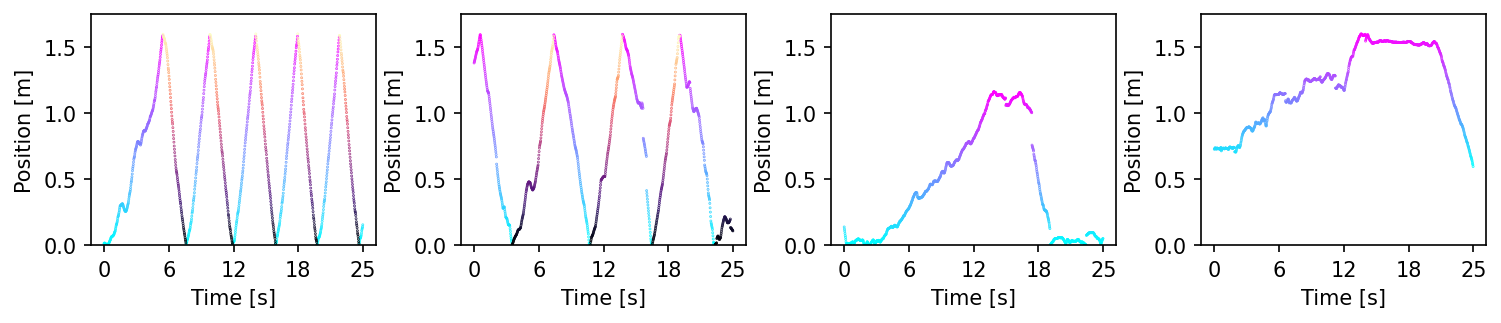

In [11]:
fig = plt.figure(figsize=(12,2), dpi=150)
plt.subplots_adjust(wspace = 0.3)

n_points = 1000 # We only select the first 1000 sample points of each dataset

for i in range(len(train_datasets)):
    ax = plt.subplot(1, 4, i+1)
    
    label = train_datasets[i].continuous[:n_points,:].cpu()
    
    r_ind = label[:, 1] == 1
    l_ind = label[:, 2] == 1

    r_cmap = "cool"
    l_cmap = "magma"
    r_c = label[r_ind, 0]
    l_c = label[l_ind, 0]

    ax.scatter(np.arange(n_points)[r_ind], label[r_ind,0], c=r_c, cmap = r_cmap, s=0.1)
    ax.scatter(np.arange(n_points)[l_ind], label[l_ind,0], c=l_c, cmap = l_cmap, s=0.1)
    ax.set_ylabel('Position [m]')
    ax.set_xlabel('Time [s]')
    ax.set_ylim([0, 1.75])
    ax.set_xticks(np.linspace(0, n_points, 5), np.linspace(0, 0.025*n_points, 5, dtype = int))
plt.show()

We can see that for Rat 3 and 4, we do not have the full range of behaviors (not to the end of the linear track).

In [12]:
# Create the 1000-samples dataset
shorter_train = train_datasets
for i in range(len(train_datasets)):
    shorter_train[i].neural = train_datasets[i].neural[:n_points,:]
    shorter_train[i].continuous = train_datasets[i].continuous[:n_points, :]

In [13]:
# Compute the embeddings, similarly to before with the same solver
embeddings = {}
for i in range(len(shorter_train)):
    embeddings[i] = solver.transform([shorter_train[j].neural for j in range(len(shorter_train))],
                                     [shorter_train[j].continuous for j in range(len(shorter_train))],
                                     session_id = i,
                                     batch_size=300).cpu().numpy()

In [14]:
markersize=2
cols = len(embeddings)
fig = make_subplots(
    rows=1,
    cols=cols,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}]],
    subplot_titles=tuple(
        np.array(
            [f"Rat {str(i+1)}" for i in range(len(embeddings))]
        )
    ),
    vertical_spacing=0,
    horizontal_spacing=0.0,
)

for i in range(len(embeddings)):
    label = shorter_train[i].continuous.cpu().numpy()
    
    r_ind = label[:, 1] == 1
    l_ind = label[:, 2] == 1
    r_map = "cool"
    l_map = "magma"
    r_c = label[r_ind, 0]
    l_c = label[l_ind, 0]

    fig = plot_embedding_interactive(
        embeddings[i][r_ind],
        r_c,
        cmap=r_map,
        axis=fig,
        row=1,
        col=i+1,
        opacity=alpha,
        markersize=markersize,
        title="",
    )
    
    fig = plot_embedding_interactive(
        embeddings[i][l_ind],
        l_c,
        cmap=l_map,
        axis=fig,
        row=1,
        col=i+1,
        opacity=alpha,
        markersize=markersize,
        title="",
    )
    
dict_layout = dict(
        xaxis = dict(
            backgroundcolor="rgba(0, 0, 0, 0)",
            gridcolor="rgba(0, 0, 0, 0)",
            showbackground=True,
            zerolinecolor="white",
        ),
        yaxis = dict(
            backgroundcolor="rgba(0, 0, 0, 0)",
            gridcolor="rgba(0, 0, 0, 0)",
            showbackground=True,
            zerolinecolor="white",
        ),
        zaxis = dict(
            backgroundcolor="rgba(0, 0, 0, 0)",
            gridcolor="rgba(0, 0, 0, 0)",
            showbackground=True,
            zerolinecolor="white",
        ))
            
fig.update_layout(
    scene = dict_layout,
    scene2= dict_layout,
    scene3= dict_layout,
    scene4= dict_layout,
    width=800,
    height=400,
)
    
fig.show()

We do see that the embeddings for Rat 3 and 4 are not complete but the trajectory is still very clear (because it was trained on the full range of behaviors).

But now, can we get a common embedding visualization? Yes, because the embeddings are infered from the latent space we can just consider all of them all together (concatenation in time).

In [15]:
# Assemble all behaviors together.
embeddings = []
for i in range(len(shorter_train)):
    embeddings.append(solver.transform([shorter_train[j].neural for j in range(len(shorter_train))],
                                     [shorter_train[j].continuous for j in range(len(shorter_train))], #NOTE: labels at inference
                                     session_id = i,
                                     batch_size=300).cpu().numpy())
embeddings = np.concatenate(embeddings)

In [16]:

fig = make_subplots(
    rows=1,
    cols=1,
    specs=[[{"type": "scatter3d"}]],
    vertical_spacing=0,
    horizontal_spacing=0.0,
)

# We concatenate the behaviors as well
label = [shorter_train[i].continuous.cpu().numpy() for i in range(len(shorter_train))]
label = np.concatenate(label)

r_ind = label[:, 1] == 1
l_ind = label[:, 2] == 1
r_map = "cool"
l_map = "magma"
r_c = label[r_ind, 0]
l_c = label[l_ind, 0]

fig = plot_embedding_interactive(
    embeddings[r_ind],
    r_c,
    cmap=r_map,
    axis=fig,
    row=1,
    col=1,
    opacity=alpha,
    markersize=markersize,
    title="",
)

fig = plot_embedding_interactive(
    embeddings[l_ind],
    l_c,
    cmap=l_map,
    axis=fig,
    row=1,
    col=1,
    markersize=markersize,
    opacity=alpha,
    title="",
)
    
dict_layout = dict(
        xaxis = dict(
            backgroundcolor="rgba(0, 0, 0, 0)",
            gridcolor="rgba(0, 0, 0, 0)",
            showbackground=True,
            zerolinecolor="white",
        ),
        yaxis = dict(
            backgroundcolor="rgba(0, 0, 0, 0)",
            gridcolor="rgba(0, 0, 0, 0)",
            showbackground=True,
            zerolinecolor="white",
        ),
        zaxis = dict(
            backgroundcolor="rgba(0, 0, 0, 0)",
            gridcolor="rgba(0, 0, 0, 0)",
            showbackground=True,
            zerolinecolor="white",
        ))
            
fig.update_layout(
    scene = dict_layout,
    width=600,
    height=600,
)
    
fig.show()